PART A

In [3]:
# 1.
import pandas as pd

df = pd.read_csv("periodic_table.csv")

df.head()

# 2.
mass_dict = pd.Series(df.AtomicMass.values, index=df.Symbol).to_dict()
print(mass_dict["H"])   # should give ~1.008
print(mass_dict["O"])   # should give ~15.999


# 3.
import re

def molecular_mass(formula, mass_dict):
    tokens = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
    
    total_mass = 0
    for (element, count) in tokens:
        count = int(count) if count else 1
        total_mass += mass_dict[element] * count
    return total_mass

print(molecular_mass("H2O", mass_dict))       # ~18.015
print(molecular_mass("C6H12O6", mass_dict))  # ~180.156

# 4. 

def parse_formula(formula, mass_dict):
    while "(" in formula:
        sub = re.search(r'\(([^()]+)\)(\d*)', formula)
        if not sub:
            break
        inside, mult = sub.groups()
        mult = int(mult) if mult else 1
        expanded = "".join([f"{el}{int(num)*mult if num else mult}" 
                            for el, num in re.findall(r'([A-Z][a-z]?)(\d*)', inside)])
        formula = formula[:sub.start()] + expanded + formula[sub.end():]
    return molecular_mass(formula, mass_dict)

print(parse_formula("Ca(OH)2", mass_dict))   # ~74.093

# 5.
def hydrated_mass(formula, mass_dict):
    parts = formula.split(".")
    total = 0
    for part in parts:
        # If part starts with a number, separate multiplier
        m = re.match(r'(\d+)(.*)', part)
        if m:
            mult, rest = m.groups()
            total += int(mult) * parse_formula(rest, mass_dict)
        else:
            total += parse_formula(part, mass_dict)
    return total

print(hydrated_mass("CuSO4.5H2O", mass_dict))   # ~249.685

1.008
15.999
18.015
180.156
74.09400000000001
249.69100000000003


PART B

In [4]:
# 1. 
import sympy as sp
import re

def parse_formula_count(formula):
    while "(" in formula:
        sub = re.search(r'\(([^()]+)\)(\d*)', formula)
        inside, mult = sub.groups()
        mult = int(mult) if mult else 1
        expanded = "".join([f"{el}{int(num)*mult if num else mult}" 
                            for el,num in re.findall(r'([A-Z][a-z]?)(\d*)', inside)])
        formula = formula[:sub.start()] + expanded + formula[sub.end():]
    counts = {}
    for el,num in re.findall(r'([A-Z][a-z]?)(\d*)', formula):
        counts[el] = counts.get(el,0) + (int(num) if num else 1)
    return counts


def balance_reaction(reactants, products):
    species = reactants + products
    n_r = len(reactants)
    elems = sorted({e for f in species for e in parse_formula_count(f)})

    # Build atom balance matrix (reactants +, products -)
    A = sp.Matrix([
        [parse_formula_count(f).get(e,0) * (1 if j < n_r else -1)
         for j,f in enumerate(species)]
        for e in elems
    ])

    ns = A.nullspace()
    if not ns:
        raise ValueError("No non-trivial solution found.")
    vec = ns[0]

    # scale to integers
    denoms = [c.as_numer_denom()[1] for c in vec]
    lcm = sp.ilcm(*denoms)
    coeffs = [int(c*lcm) for c in vec]

    # make positive
    if any(c < 0 for c in coeffs):
        coeffs = [-c for c in coeffs]

    # reduce by gcd
    from math import gcd
    g = gcd(*(c for c in coeffs if c != 0))
    coeffs = [c//g for c in coeffs]

    return coeffs


print(balance_reaction(["H2", "O2"], ["H2O"]))  
# Expected: [2,1,2]

print(balance_reaction(["C2H6","O2"], ["CO2","H2O"]))  
# Expected: [2,7,4,6]

print(balance_reaction(["Fe","O2"], ["Fe2O3"]))  
# Expected: [4,3,2]


# 2.
def mass_conserved(reactants, products, coeffs, mass_dict):
    n = len(reactants)
    rm = sum(hydrated_mass(r, mass_dict)*coeffs[i] for i,r in enumerate(reactants))
    pm = sum(hydrated_mass(p, mass_dict)*coeffs[n+i] for i,p in enumerate(products))
    return abs(rm - pm) < 1e-6


coeffs = balance_reaction(["H2", "O2"], ["H2O"])
print(mass_conserved(["H2", "O2"], ["H2O"], coeffs, mass_dict))  # True


ModuleNotFoundError: No module named 'sympy'

PART C

The idea is to estimate π using random sampling. If we throw points randomly inside a square of side 2 (from –1 to 1 in both x and y), the ratio of points inside the unit circle compared to the total points should approximate the area ratio (π/4). Multiplying this ratio by 4 gives an estimate of π. The accuracy improves as the number of points increases.

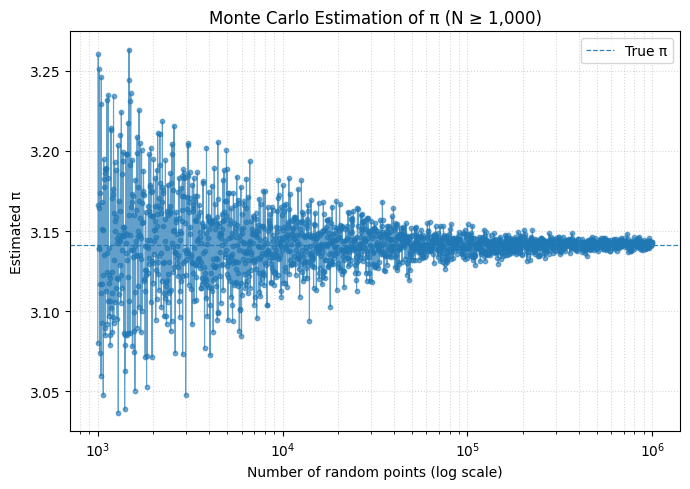

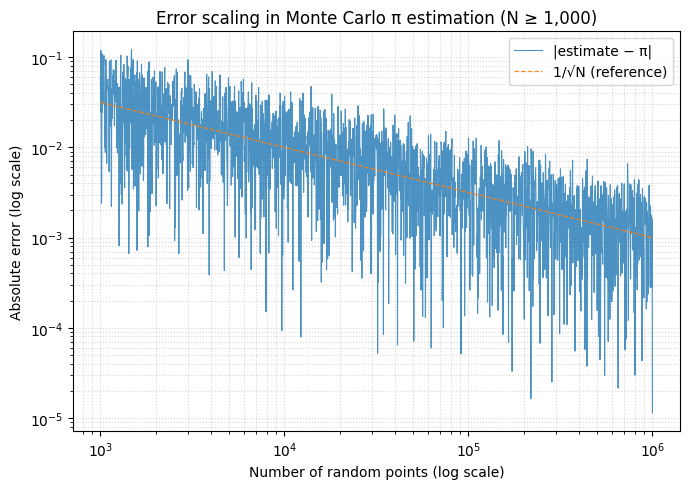

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from math import pi

rng = np.random.default_rng(42)

def estimate_pi(N, rng=rng):
    """Estimate π using N random points inside [-1,1] x [-1,1]."""
    x = rng.uniform(-1.0, 1.0, N)
    y = rng.uniform(-1.0, 1.0, N)
    inside = (x*x + y*y) <= 1.0
    return 4.0 * inside.mean()

# Use many N, but start at 1e3 to satisfy your constraint
N_min, N_max = 10**3, 10**6
num_points = 2000
Ns = np.unique(np.logspace(np.log10(N_min), np.log10(N_max), num=num_points).astype(int))

pi_estimates = np.array([estimate_pi(N) for N in Ns])
errors = np.abs(pi_estimates - pi)

# 1) π estimate vs N — use scatter + thin line to avoid "cone"
plt.figure(figsize=(7,5))
plt.plot(Ns, pi_estimates, linewidth=0.8, alpha=0.7)       # thin line
plt.scatter(Ns, pi_estimates, s=10, alpha=0.6)             # small markers
plt.axhline(pi, linestyle="--", linewidth=0.9, alpha=0.9, label="True π")
plt.xscale("log")
plt.xlabel("Number of random points (log scale)")
plt.ylabel("Estimated π")
plt.title("Monte Carlo Estimation of π (N ≥ 1,000)")
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Error vs N — thin line + small markers
plt.figure(figsize=(7,5))
plt.loglog(Ns, errors, linewidth=0.8, alpha=0.8, label="|estimate − π|")
plt.loglog(Ns, 1/np.sqrt(Ns), "--", linewidth=0.9, alpha=0.9, label="1/√N (reference)")
plt.xlabel("Number of random points (log scale)")
plt.ylabel("Absolute error (log scale)")
plt.title("Error scaling in Monte Carlo π estimation (N ≥ 1,000)")
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In this simulation we treat molecular collisions in a box. Each collision is assigned a random energy (either uniform or normal distribution). If the energy is above a chosen threshold, we say the collision is “reactive”. The fraction of reactive collisions is interpreted as the probability of reaction. This is a simplified analogy to real chemical systems where only collisions with enough energy lead to reaction.

Estimated reaction probability: 0.309


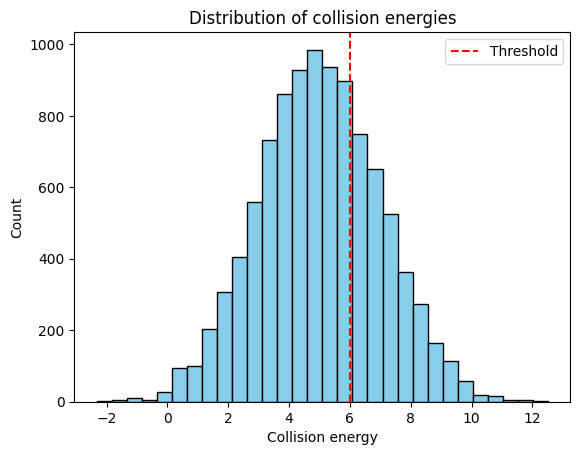

In [6]:
def simulate_collisions(M, threshold=5.0, mode="uniform"):
    """Simulate M collisions and estimate reaction probability."""
    if mode == "uniform":
        energies = np.random.uniform(0, 10, M)
    elif mode == "normal":
        energies = np.random.normal(loc=5, scale=2, size=M)
    else:
        raise ValueError("mode must be 'uniform' or 'normal'")
    
    reactive = np.sum(energies > threshold)
    prob = reactive / M
    return prob, energies

# Example run
prob, energies = simulate_collisions(10000, threshold=6, mode="normal")
print(f"Estimated reaction probability: {prob:.3f}")

# Plot energy distribution
plt.hist(energies, bins=30, color="skyblue", edgecolor="black")
plt.axvline(6, color="red", linestyle="--", label="Threshold")
plt.xlabel("Collision energy")
plt.ylabel("Count")
plt.title("Distribution of collision energies")
plt.legend()
plt.show()